# Downdrafts in Idealised Soundings

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we create several idealised soundings and use them for downdraft calculations.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate
from metpy.plots import SkewT
from pint import set_application_registry
set_application_registry(units)

from scipy.integrate import simps, solve_ivp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar, minimize_scalar

import sys
from os import mkdir
from os.path import exists
import shelve

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, saturation_specific_humidity, dcape_dcin
from thermo import temperature_change
from entraining_parcel import EntrainingParcel

## Creating the soundings
Following Chapter 9 (*The Atmospheric Boundary Layer*) of *Atmospheric Science : An Introductory Survey* by Wallace and Hobbs (2006):
- The boundary layer is usually 1-2 km thick with roughly uniform potential temperature and mixing ratio
- It is bounded above by a capping inversion in which temperature increases with height

We will use:
- A surface pressure of 1013.25 mbar and surface temperature 20C
- A 160 mbar thick (~1.5 km) boundary layer with dry adiabatic (uniform potential temperature) temperature profile and a uniform mixing ratio of 6 g/kg
- A 10 mbar thick (~100 m) capping inversion where temperature increases by 3C with height
- A moist adiabatic temperature profile in the rest of the atmosphere, with constant relative humidity

In [2]:
def idealised_sounding(relative_humidity, info='', name=''):
    """
    Creates an idealised sounding.
    
    Args:
        relative_humidity: Relative humidity above the boundary layer.
        info: Information to store with the sounding, e.g. date
            (optional)
        name: Short name for the sounding, e.g. 'Sydney' (optional).
        
    Returns:
        An Environment instance.
    """
    
    # generature temperature profile
    pressure = np.arange(1013.25, 200, -5)*units.mbar
    t_boundary_layer = mpcalc.dry_lapse(
        np.arange(1013.25, 1013.25 - 161, -5)*units.mbar, 20*units.celsius)
    t_capping = t_boundary_layer[-1] + [1.5, 3.0]*units.delta_degC
    t_remaining = mpcalc.moist_lapse(
        np.arange(1013.25 - 175, 200, -5)*units.mbar, t_capping[-1],
        reference_pressure=(1013.25 - 170)*units.mbar)
    temperature = concatenate([
        t_boundary_layer, t_capping, t_remaining,
    ])

    # generate dew point profile
    q_boundary_layer = mpcalc.specific_humidity_from_mixing_ratio(
        6e-3*units.dimensionless)
    dewpoint_boundary_layer = mpcalc.dewpoint_from_specific_humidity(
        np.arange(1013.25, 1013.25 - 161, -5)*units.mbar, t_boundary_layer,
        np.ones(t_boundary_layer.size)*q_boundary_layer)
    dewpoint_remaining = mpcalc.dewpoint_from_relative_humidity(
        t_remaining, np.ones(t_remaining.size)*relative_humidity)
    dewpoint_capping_top = mpcalc.dewpoint_from_relative_humidity(
        t_capping[-1], relative_humidity)
    dewpoint_capping = concatenate([
        (dewpoint_boundary_layer[-1].to(units.kelvin)
         + dewpoint_capping_top.to(units.kelvin))/2,
        dewpoint_capping_top,
    ])
    dewpoint = concatenate([
        dewpoint_boundary_layer, dewpoint_capping, dewpoint_remaining,
    ])
    
    temperature_interp = interp1d(
        pressure.m_as(units.pascal), temperature.m_as(units.kelvin),
        fill_value='extrapolate')
    dewpoint_interp = interp1d(
        pressure.m_as(units.pascal), dewpoint.m_as(units.kelvin),
        fill_value='extrapolate')
    
    def dzdp(pressure, height):
        """
        Calculates the rate of height change w.r.t. pressure, dz/dp.
        Args:
            pressure: The pressure at the point of interest, in Pa.
            height: The height of the point of interest, in m.
        Returns:
            The derivative dz/dp in m/Pa.
        """

        pressure = pressure*units.pascal
        temperature = temperature_interp(pressure.m)*units.kelvin
        dewpoint = dewpoint_interp(pressure.m)*units.kelvin

        specific_humidity = mpcalc.specific_humidity_from_dewpoint(
            pressure, dewpoint)
        mixing_ratio = mpcalc.mixing_ratio_from_specific_humidity(
            specific_humidity)
        density = mpcalc.density(pressure, temperature, mixing_ratio)
        dzdp = - 1 / (density.to(units.kg/units.meter**3).m * const.g)

        return dzdp

    height = solve_ivp(
        dzdp, (1013.25e2, np.min(pressure.m_as(units.pascal))),
        [0], t_eval=pressure.m_as(units.pascal)).y*units.meter
    
    return Environment(
        pressure, np.squeeze(height), temperature, dewpoint, info=info,
        name=name)

In [4]:
relative_humidity = np.arange(0.3, 0.91, 0.2)*units.dimensionless
soundings = [idealised_sounding(rh) for rh in relative_humidity]
for sounding in soundings:
    dcape, dcin = dcape_dcin(sounding, samples=100)
    sounding.dcape = dcape
    sounding.dcin = dcin

In [16]:
parcels = [EntrainingParcel(sounding) for sounding in soundings]

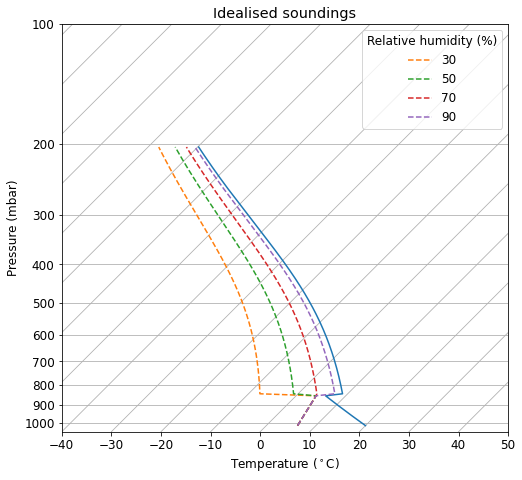

In [20]:
fig = plt.figure(figsize=(8,8))
skew = SkewT(fig, rotation=45)
skew.plot(soundings[0]._pressure_raw, soundings[0]._temperature_raw)
for sounding, rh in zip(soundings, relative_humidity):
    skew.plot(sounding._pressure_raw, sounding._dewpoint_raw, '--',
              label='{:.0f}'.format(rh.m*100))
lgd = skew.ax.legend()
lgd.set_title('Relative humidity (%)')
skew.ax.set(
    xlabel='Temperature ($^\circ$C)',
    ylabel='Pressure (mbar)',
    title='Idealised soundings')
plt.show()

## Varying entrainment rate

In [17]:
%%time
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = soundings[0].pressure(z_initial)
t_initial = soundings[0].wetbulb_temperature(z_initial)
q_initial = saturation_specific_humidity(p_initial, t_initial)
time = np.arange(0, 10.1, 0.1)*units.minute
rates = np.arange(0, 2.1, 0.5)/units.km
l_initial = 2e-3*units.dimensionless

sols = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, rates.size))
    sol = parcels[0].motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate)
    sols.append(sol)
sys.stdout.write('\n')

Calculation 5 of 5
CPU times: user 1min 32s, sys: 976 ms, total: 1min 33s
Wall time: 1min 37s


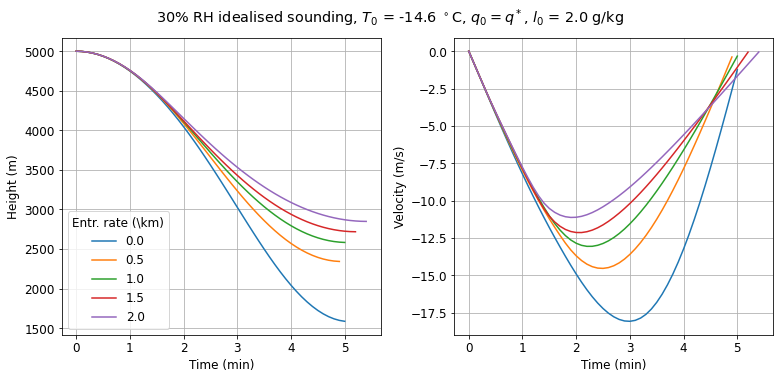

In [23]:
# simple height/velocity plot
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols):
    ax1.plot(time, sol.height, label=str(rates[i].m))
    ax2.plot(time, sol.velocity)
    
ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
lgd = ax1.legend(loc='lower left')
lgd.set_title('Entr. rate (\km)')
ax1.grid()
ax2.grid()

fig.tight_layout()
fig.suptitle(
    '30% RH idealised sounding, $T_0$ = {:.1f} $^\circ$C, $q_0 = q^*$, '
    '$l_0$ = {:.1f} g/kg'.format(t_initial.m, l_initial.m*1e3),
    y=1.05)
plt.show()

In [24]:
%%time
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = soundings[3].pressure(z_initial)
t_initial = soundings[3].wetbulb_temperature(z_initial)
q_initial = saturation_specific_humidity(p_initial, t_initial)
time = np.arange(0, 10.1, 0.1)*units.minute
rates = np.arange(0, 2.1, 0.5)/units.km
l_initial = 2e-3*units.dimensionless

sols = []
for i, rate in enumerate(rates):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, rates.size))
    sol = parcels[3].motion(
        time, z_initial, w_initial, t_initial, q_initial, l_initial, rate)
    sols.append(sol)
sys.stdout.write('\n')

Calculation 5 of 5
CPU times: user 1min 58s, sys: 327 ms, total: 1min 58s
Wall time: 1min 59s


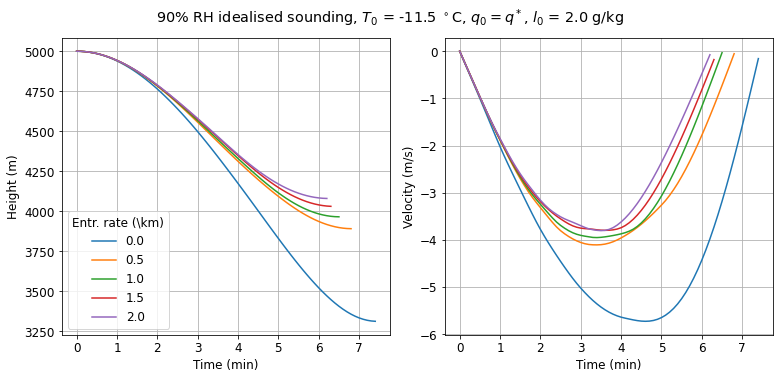

In [25]:
# simple height/velocity plot
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols):
    ax1.plot(time, sol.height, label=str(rates[i].m))
    ax2.plot(time, sol.velocity)
    
ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
lgd = ax1.legend(loc='lower left')
lgd.set_title('Entr. rate (\km)')
ax1.grid()
ax2.grid()

fig.tight_layout()
fig.suptitle(
    '90% RH idealised sounding, $T_0$ = {:.1f} $^\circ$C, $q_0 = q^*$, '
    '$l_0$ = {:.1f} g/kg'.format(t_initial.m, l_initial.m*1e3),
    y=1.05)
plt.show()

The parcel in the 90% RH sounding does not descend as far as the one in the 30% RH sounding, at least partly because the amount of initial cooling by evaporation is smaller. It is interesting to note that the dependence on entrainment rate is more nonlinear.

## Varying initial temperature
Entrainment rate is fixed at 1/km

In [28]:
%%time
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = soundings[0].pressure(z_initial)

env_q = soundings[0].specific_humidity(z_initial)
max_dq = soundings[0].maximum_specific_humidity_change(z_initial)
wetbulb = soundings[0].wetbulb_temperature(z_initial)
q_initial = np.concatenate(
    (np.linspace(env_q, env_q + max_dq, 6)[1:-1],
     np.ones(6)*saturation_specific_humidity(p_initial, wetbulb)))
l_initial = np.concatenate((np.zeros(5), np.linspace(0, 2e-3, 6)[1:]))
t_initial = np.concatenate((
    soundings[0].temperature(z_initial) + temperature_change(q_initial[0:4] - env_q),
    np.ones(6)*wetbulb))

time = np.arange(0, 10.1, 0.1)*units.minute
rate = 1/units.km

sols = []
i = 0
for t, q, l in zip(t_initial, q_initial, l_initial):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, t_initial.size))
    sol = parcels[0].motion(time, z_initial, w_initial, t, q, l, rate)
    sols.append(sol)
    i += 1
sys.stdout.write('\n')

Calculation 10 of 10
CPU times: user 1min 12s, sys: 514 ms, total: 1min 12s
Wall time: 1min 14s


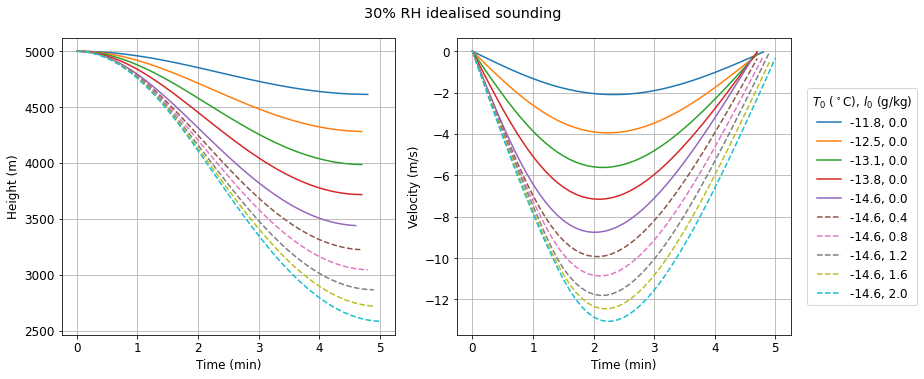

In [36]:
# simple height/velocity plot
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols[0:5]):
    ax1.plot(time, sol.height)
    ax2.plot(time, sol.velocity,
             label='{:.1f}, {:.1f}'.format(t_initial[i].m, l_initial[i]*1e3))
    
for i, sol in enumerate(sols[5:]):
    ax1.plot(time, sol.height, '--')
    ax2.plot(time, sol.velocity, '--',
             label='{:.1f}, {:.1f}'.format(t_initial[i+5].m, l_initial[i+5]*1e3))

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax2.grid()
lgd = ax2.legend(loc=(1.05, 0.1))
lgd.set_title('$T_0$ ($^\circ$C), $l_0$ (g/kg)')

fig.tight_layout()
fig.suptitle('30% RH idealised sounding', y=1.05)
plt.show()

In [37]:
%%time
z_initial = 5*units.km
w_initial = 0*units.meter/units.second
p_initial = soundings[3].pressure(z_initial)

env_q = soundings[3].specific_humidity(z_initial)
max_dq = soundings[3].maximum_specific_humidity_change(z_initial)
wetbulb = soundings[3].wetbulb_temperature(z_initial)
q_initial = np.concatenate(
    (np.linspace(env_q, env_q + max_dq, 6)[1:-1],
     np.ones(6)*saturation_specific_humidity(p_initial, wetbulb)))
l_initial = np.concatenate((np.zeros(5), np.linspace(0, 2e-3, 6)[1:]))
t_initial = np.concatenate((
    soundings[3].temperature(z_initial) + temperature_change(q_initial[0:4] - env_q),
    np.ones(6)*wetbulb))

time = np.arange(0, 10.1, 0.1)*units.minute
rate = 1/units.km

sols = []
i = 0
for t, q, l in zip(t_initial, q_initial, l_initial):
    sys.stdout.write('\rCalculation {} of {}'.format(i+1, t_initial.size))
    sol = parcels[3].motion(time, z_initial, w_initial, t, q, l, rate)
    sols.append(sol)
    i += 1
sys.stdout.write('\n')

Calculation 10 of 10
CPU times: user 1min 39s, sys: 585 ms, total: 1min 39s
Wall time: 1min 42s


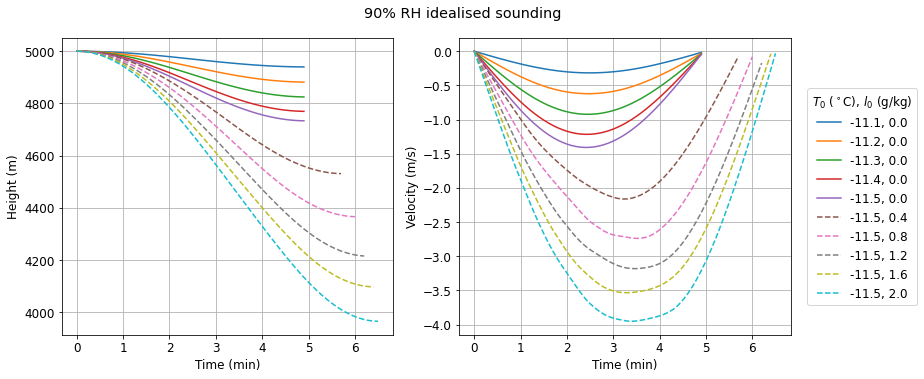

In [38]:
# simple height/velocity plot
fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i, sol in enumerate(sols[0:5]):
    ax1.plot(time, sol.height)
    ax2.plot(time, sol.velocity,
             label='{:.1f}, {:.1f}'.format(t_initial[i].m, l_initial[i]*1e3))
    
for i, sol in enumerate(sols[5:]):
    ax1.plot(time, sol.height, '--')
    ax2.plot(time, sol.velocity, '--',
             label='{:.1f}, {:.1f}'.format(t_initial[i+5].m, l_initial[i+5]*1e3))

ax1.set(
    xlabel='Time (min)',
    ylabel='Height (m)')
ax2.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)')
ax1.grid()
ax2.grid()
lgd = ax2.legend(loc=(1.05, 0.1))
lgd.set_title('$T_0$ ($^\circ$C), $l_0$ (g/kg)')

fig.tight_layout()
fig.suptitle('90% RH idealised sounding', y=1.05)
plt.show()

## Next steps
- See if I can fix the reversible adiabat calculation
- Experiment with a wider range of idealised soundings and check for correlation with DCAPE and DCIN
- Write first draft of report, send before next meeting
- Try to explain nonlinear entrainment rate dependence
    - Consider liquid loading term, maybe omit